<a href="https://colab.research.google.com/github/MavelSterling/Lab-curso-NLP/blob/main/Sesion1/7-sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Sentimientos con VADER (Tweets) + Extensiones

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MavelSterling/Lab-curso-NLP/blob/main/Sesion1/7-sentiment-analysis.ipynb)

En este notebook realizamos un análisis de sentimientos binario (positivo vs negativo) usando el modelo VADER de NLTK, pero en lugar de reseñas de películas, usaremos un dataset diferente: tweets etiquetados (twitter_samples de NLTK).

### Referencias
* [Análisis de sentimiento de VADER](https://hex.tech/templates/sentiment-analysis/vader-sentiment-analysis/)

# Prerequisitos



In [1]:
# Instalación dependencias
import sys, pkgutil

def pip_install(pkgs):
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

needed = ["pandas", "numpy", "scikit-learn", "matplotlib", "nltk"]
pip_install(needed)

print("Listo: dependencias instaladas.")


Listo: dependencias instaladas.


In [2]:
# Importaciones

import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)

SEED = 42
np.random.seed(SEED)

print("Imports OK.")


Imports OK.


# Dataset

Usaremos el corpus twitter_samples de NLTK, que trae:
- Tweets positivos
- Tweets negativos

Construimos un DataFrame con columnas:
- text: tweet
- label: pos o neg


In [3]:
import nltk
nltk.download("twitter_samples")

from nltk.corpus import twitter_samples

pos_tweets = twitter_samples.strings("positive_tweets.json")
neg_tweets = twitter_samples.strings("negative_tweets.json")

df_pos = pd.DataFrame({"text": pos_tweets, "label": "pos"})
df_neg = pd.DataFrame({"text": neg_tweets, "label": "neg"})
df = pd.concat([df_pos, df_neg], axis=0, ignore_index=True)

df.head(), df.label.value_counts()


[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


(                                                text label
 0  #FollowFriday @France_Inte @PKuchly57 @Milipol...   pos
 1  @Lamb2ja Hey James! How odd :/ Please call our...   pos
 2  @DespiteOfficial we had a listen last night :)...   pos
 3                               @97sides CONGRATS :)   pos
 4  yeaaaah yippppy!!!  my accnt verified rqst has...   pos,
 label
 pos    5000
 neg    5000
 Name: count, dtype: int64)

# Limpieza mínima de texto

En tweets es común encontrar:
- URLs
- menciones (@usuario)
- múltiples espacios

Haremos una limpieza suave (sin destruir emojis), ya que VADER usa señales como emoticonos y signos.


In [4]:
def clean_tweet(t: str) -> str:
    t = t.replace("\n", " ")
    t = re.sub(r"http\S+|www\.\S+", "", t)     # quitar URLs
    t = re.sub(r"@\w+", "", t)                # quitar menciones
    t = re.sub(r"\s+", " ", t).strip()        # normalizar espacios
    return t

df["text_clean"] = df["text"].astype(str).apply(clean_tweet)

# Remover vacíos (por seguridad)
df = df[df["text_clean"].str.len() > 0].reset_index(drop=True)

df[["text", "text_clean", "label"]].head()


,text,text_clean,label
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,#FollowFriday for being top engaged members in...,pos
1,@Lamb2ja Hey James! How odd :/ Please call our...,Hey James! How odd :/ Please call our Contact ...,pos
2,@DespiteOfficial we had a listen last night :)...,we had a listen last night :) As You Bleed is ...,pos
3,@97sides CONGRATS :),CONGRATS :),pos
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy!!! my accnt verified rqst has ...,pos


#Separar en train/test

Aunque VADER no “entrena”, separar en test ayuda a:
- evaluar de forma más realista
- ajustar el umbral en train y reportar desempeño final en test


In [5]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.label.value_counts(), test_df.label.value_counts()


(label
 neg    4000
 pos    4000
 Name: count, dtype: int64,
 label
 neg    1000
 pos    1000
 Name: count, dtype: int64)

# Línea base: VADER

En esta parte usamos VADER para obtener, para cada texto, cuatro puntajes: negativo, neutral, positivo y compound. El puntaje compound resume el sentimiento global en un solo número entre -1 y 1: valores cercanos a -1 indican más negatividad y valores cercanos a 1 indican más positividad.

Para convertir ese número en una etiqueta y poder evaluar el modelo, aplicamos una regla simple (línea base): si compound es mayor o igual a 0 lo marcamos como pos, y si es menor que 0 lo marcamos como neg. Esta regla es la misma idea del notebook guía, solo que aquí la aplicamos a nuestros datos.


In [6]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def vader_compound(text: str) -> float:
    return sid.polarity_scores(text)["compound"]

train_df["compound"] = train_df["text_clean"].apply(vader_compound)
test_df["compound"]  = test_df["text_clean"].apply(vader_compound)

# Umbral baseline
baseline_threshold = 0.0
test_df["vader_pred_baseline"] = np.where(test_df["compound"] >= baseline_threshold, "pos", "neg")

test_df[["text_clean", "label", "compound", "vader_pred_baseline"]].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,text_clean,label,compound,vader_pred_baseline
0,:(( but I want to get at least a little bit ol...,neg,0.8294,pos
1,that's all ok I know your busy :),pos,0.6369,pos
2,naeun :( body goals :(,neg,-0.7003,neg
3,"Ok,the first time we chat,and then i made such...",pos,0.4915,pos
4,everything okay? :( x,neg,-0.2500,neg


## Métricas del baseline (VADER con umbral 0)

Calculo:
- Accuracy
- F1 (considerando pos como clase positiva)
- Matriz de confusión y reporte por clase

Es normal que VADER falle en ironía/sarcasmo, abreviaciones o contexto.
Por eso esperamos ver errores cerca de compound ≈ 0 o en textos con expresiones ambiguas.


In [7]:
y_true = test_df["label"].values
y_pred = test_df["vader_pred_baseline"].values

acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, pos_label="pos")
cm  = confusion_matrix(y_true, y_pred, labels=["neg", "pos"])
cr  = classification_report(y_true, y_pred, labels=["neg", "pos"])

print(f"VADER baseline (threshold={baseline_threshold})")
print(f"Accuracy: {acc:.4f}")
print(f"F1 (pos): {f1:.4f}\n")
print("Classification report:\n", cr)
print("Confusion matrix [neg,pos] rows x [neg,pos] cols:\n", cm)


VADER baseline (threshold=0.0)
Accuracy: 0.8275
F1 (pos): 0.8474

Classification report:
               precision    recall  f1-score   support

         neg       0.94      0.70      0.80      1000
         pos       0.76      0.96      0.85      1000

    accuracy                           0.83      2000
   macro avg       0.85      0.83      0.82      2000
weighted avg       0.85      0.83      0.82      2000

Confusion matrix [neg,pos] rows x [neg,pos] cols:
 [[697 303]
 [ 42 958]]


#Visualización: distribución de compound por clase real

Esto nos permite ver:
- si los tweets positivos tienden a compound > 0
- si los negativos tienden a compound < 0
- qué tan grande es la zona “gris” cerca de 0 (donde suele haber confusión)


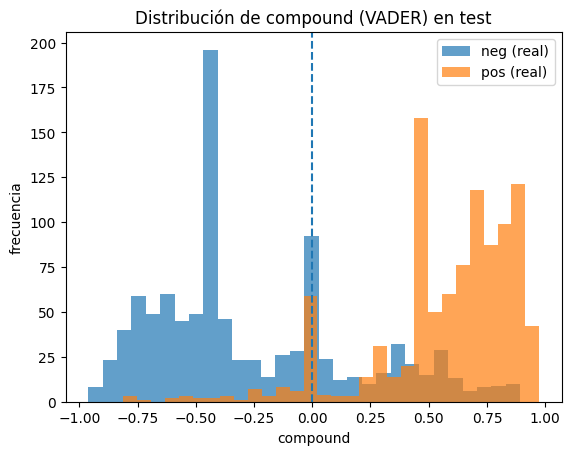

In [8]:
plt.figure()
neg_scores = test_df.loc[test_df["label"] == "neg", "compound"].values
pos_scores = test_df.loc[test_df["label"] == "pos", "compound"].values

plt.hist(neg_scores, bins=30, alpha=0.7, label="neg (real)")
plt.hist(pos_scores, bins=30, alpha=0.7, label="pos (real)")
plt.axvline(0.0, linestyle="--")
plt.title("Distribución de compound (VADER) en test")
plt.xlabel("compound")
plt.ylabel("frecuencia")
plt.legend()
plt.show()


#Matriz de confusión (plot)

Visualizamos la matriz para identificar si el problema está más en falsos positivos o falsos negativos.


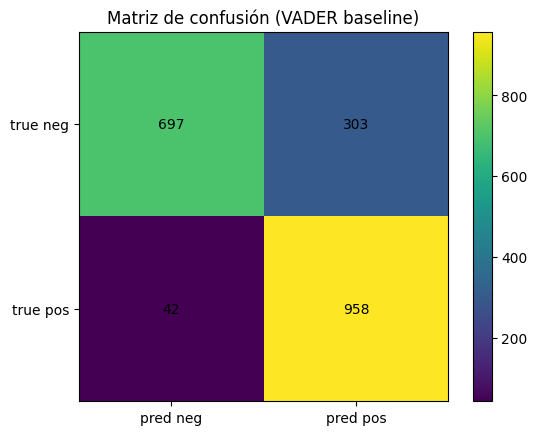

In [9]:
plt.figure()
plt.imshow(cm)
plt.title("Matriz de confusión (VADER baseline)")

plt.xticks([0, 1], ["pred neg", "pred pos"])
plt.yticks([0, 1], ["true neg", "true pos"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.show()


#Análisis de errores: ejemplos mal clasificados

Nos interesa mirar:
- tweets con *compound* muy cercano a 0
- mensajes con ironía/sarcasmo o frases cortas




In [10]:
errs = test_df[test_df["label"] != test_df["vader_pred_baseline"]].copy()
errs["abs_compound"] = errs["compound"].abs()
errs_sorted = errs.sort_values("abs_compound", ascending=True)

print(f"Total errores en test (baseline): {len(errs_sorted)}\n")

# Mostrar 12 errores más "difíciles" (compound más cerca de 0)
to_show = errs_sorted.head(12)[["text_clean", "label", "compound", "vader_pred_baseline"]]
to_show


Total errores en test (baseline): 345



,text_clean,label,compound,vader_pred_baseline
1996,we'll never be as young as we are now... AS YO...,neg,0.0,pos
87,are you 100% sure you lost it in your house?? :((,neg,0.0,pos
90,"morning , i miss you :( :*",neg,0.0,pos
95,Babyy :(((,neg,0.0,pos
125,"To my fellow morning owls, surely you have not...",neg,0.0,pos
1772,Why do developers release good games during sc...,neg,0.0,pos
1797,but i wasn't :-((,neg,0.0,pos
1784,it was good as always 😀Flying back today thoug...,neg,0.0,pos
274,why beh :((,neg,0.0,pos
1614,All is fair in love and war kapan update :( Oh...,neg,0.0,pos


## Ajuste de umbral

En lugar de fijar el umbral en 0, lo optimizamos en TRAIN buscando el mejor F1.
Luego aplicamos ese umbral a TEST y volvemos a reportar métricas.

En tweets, cambiar el umbral suele ayudar porque el lenguaje corto y ambiguo hace que muchos casos se acumulen cerca de 0.


Mejor umbral en TRAIN (por F1): 0.270 | F1(train)=0.8712


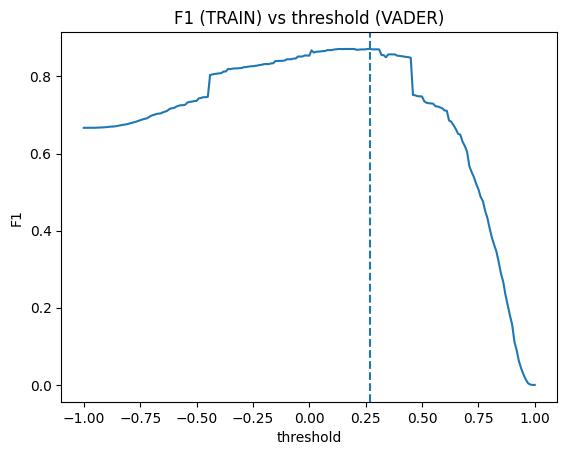

In [11]:
thresholds = np.linspace(-1, 1, 201)

best_thr = None
best_f1 = -1

y_train_true = train_df["label"].values
train_comp = train_df["compound"].values

for thr in thresholds:
    y_train_pred = np.where(train_comp >= thr, "pos", "neg")
    cur_f1 = f1_score(y_train_true, y_train_pred, pos_label="pos")
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        best_thr = float(thr)

print(f"Mejor umbral en TRAIN (por F1): {best_thr:.3f} | F1(train)={best_f1:.4f}")

# Curva F1 vs threshold (TRAIN)
f1s = []
for thr in thresholds:
    y_train_pred = np.where(train_comp >= thr, "pos", "neg")
    f1s.append(f1_score(y_train_true, y_train_pred, pos_label="pos"))

plt.figure()
plt.plot(thresholds, f1s)
plt.axvline(best_thr, linestyle="--")
plt.title("F1 (TRAIN) vs threshold (VADER)")
plt.xlabel("threshold")
plt.ylabel("F1")
plt.show()


#Métricas finales de VADER con umbral optimizado (en TEST)

Aplicamos el umbral hallado en TRAIN a TEST para reportar el desempeño final.


In [12]:
test_df["vader_pred_tuned"] = np.where(test_df["compound"] >= best_thr, "pos", "neg")

y_true = test_df["label"].values
y_pred_tuned = test_df["vader_pred_tuned"].values

acc_tuned = accuracy_score(y_true, y_pred_tuned)
f1_tuned  = f1_score(y_true, y_pred_tuned, pos_label="pos")
cm_tuned  = confusion_matrix(y_true, y_pred_tuned, labels=["neg", "pos"])
cr_tuned  = classification_report(y_true, y_pred_tuned, labels=["neg", "pos"])

print(f"VADER tuned (threshold={best_thr:.3f})")
print(f"Accuracy: {acc_tuned:.4f}")
print(f"F1 (pos): {f1_tuned:.4f}\n")
print("Classification report:\n", cr_tuned)
print("Confusion matrix [neg,pos] rows x [neg,pos] cols:\n", cm_tuned)


VADER tuned (threshold=0.270)
Accuracy: 0.8570
F1 (pos): 0.8597

Classification report:
               precision    recall  f1-score   support

         neg       0.87      0.84      0.85      1000
         pos       0.84      0.88      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Confusion matrix [neg,pos] rows x [neg,pos] cols:
 [[838 162]
 [124 876]]


#Comparación: TF-IDF + Regresión Logística

Ahora entrenamos un modelo supervisado clásico:
- Vectorización TF-IDF (unigramas + bigramas)
- Regresión Logística



In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

clf = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2)),
    ("lr", LogisticRegression(max_iter=2000, random_state=SEED))
])

X_train = train_df["text_clean"].values
y_train = train_df["label"].values
X_test  = test_df["text_clean"].values
y_test  = test_df["label"].values

clf.fit(X_train, y_train)
lr_pred = clf.predict(X_test)

acc_lr = accuracy_score(y_test, lr_pred)
f1_lr  = f1_score(y_test, lr_pred, pos_label="pos")
cm_lr  = confusion_matrix(y_test, lr_pred, labels=["neg", "pos"])
cr_lr  = classification_report(y_test, lr_pred, labels=["neg", "pos"])

print("TF-IDF + Logistic Regression (TEST)")
print(f"Accuracy: {acc_lr:.4f}")
print(f"F1 (pos): {f1_lr:.4f}\n")
print("Classification report:\n", cr_lr)
print("Confusion matrix [neg,pos] rows x [neg,pos] cols:\n", cm_lr)


TF-IDF + Logistic Regression (TEST)
Accuracy: 0.7525
F1 (pos): 0.7442

Classification report:
               precision    recall  f1-score   support

         neg       0.74      0.79      0.76      1000
         pos       0.77      0.72      0.74      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000

Confusion matrix [neg,pos] rows x [neg,pos] cols:
 [[785 215]
 [280 720]]


#Features más influyentes (interpretación del modelo)

Extraemos las palabras/frases (n-gramas) que empujan el modelo hacia pos o hacia neg.
Esto ayuda a entender qué señales aprendió el clasificador en el dataset de tweets.


In [14]:
# Extraer features (n-gramas) y coeficientes
tfidf = clf.named_steps["tfidf"]
lr = clf.named_steps["lr"]

feature_names = np.array(tfidf.get_feature_names_out())
coefs = lr.coef_[0]  # clase "pos" vs "neg"

top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]

top_pos = list(zip(feature_names[top_pos_idx], coefs[top_pos_idx]))
top_neg = list(zip(feature_names[top_neg_idx], coefs[top_neg_idx]))

print("Top 20 señales POS (n-gramas):")
for w, c in top_pos:
    print(f"{w:>20s}  {c: .4f}")

print("\nTop 20 señales NEG (n-gramas):")
for w, c in top_neg:
    print(f"{w:>20s}  {c: .4f}")


Top 20 señales POS (n-gramas):
              thanks   4.5021
               thank   3.9213
               happy   3.3147
               great   3.1593
                nice   2.6779
             welcome   2.4650
                glad   2.4295
             morning   2.3857
               fback   2.3579
                  ff   2.2264
             awesome   2.2180
              friday   2.0842
          amp follow   2.0566
                cool   2.0277
           goodnight   1.9959
               enjoy   1.9199
              lovely   1.8538
          follow amp   1.8489
              course   1.8420
flipkartfashionfriday   1.8235

Top 20 señales NEG (n-gramas):
                 sad  -3.7586
                miss  -3.7158
               sorry  -3.0605
     thanks followed  -2.5697
                wish  -2.5429
               tired  -2.3876
                want  -2.3851
             missing  -2.3668
     followed thanks  -2.2248
               wanna  -2.0624
                didn  -2.0410
      